In [10]:
# Imports
import os, sys
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import root_numpy as rtnp
import pandas
from math import log10, floor
import math
from subprocess import Popen
import shlex 
import cmsstyle


In [35]:
# Input: Different signals and trainings with varying amount of injected signal
#  RSGraviton_WW_BROAD_13TeV_PU40_1.5TeV_reco.h5
#  RSGraviton_WW_BROAD_13TeV_PU40_2.5TeV_reco.h5
#  RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV_reco.h5
#  RSGraviton_WW_BROAD_13TeV_PU40_4.5TeV_reco.h5
#  RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_reco.h5
#  RSGraviton_WW_NARROW_13TeV_PU40_2.5TeV_reco.h5
#  RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_reco.h5
#  RSGraviton_WW_NARROW_13TeV_PU40_4.5TeV_reco.h5

tag = 'PDinj_BR3p5'
# signal  = 'RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV'
signal  = 'RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV'
# xsecs   = [0,100]
# xsecs   = [0,20]
xsecs   = [0]
mX = (float(signal.split('_')[-1][:3]))
width =(signal.split('_')[2].lower())

In [36]:
# Rescaling the inputs to lumi
qcd_xsec       = 8730000.0 # Crossection in fb             
qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec       = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events = 972050.0 #(all generated signal)
lumi           = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = 0.8*sig_xsec*lumi/sig_gen_events #20% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.981237457
Scale QCD with 1.0
Scale signal with 0.000526567460168


In [37]:
# Set binning
useDijet = True

# Dijet variable-binwidth binning (depends on dijet resolution)
if useDijet:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327,
                          5574, 5737, 5951, 6173, 6402, 6638, 6882]).astype('float')
if useDijet:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
# Constant binwidth
else:
    bin_edges = np.array(np.arange(1200.,5500., 100.).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800


n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]
bws = (max_bin-min_bin)/n_bins

print(bin_edges)
print('Nbins = {} width = {}'.format(n_bins,bws))

#Define some parameters:
# path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_113/{}/xsec_0/loss_rk5_05/'.format(signal)
# path= '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/QR_models/envelope/fitted_selections/run_113/xsec_0/loss_rk5_05/param5/'
path = 'fitted_qr/xs{}/'.format(int(xsecs[0]))
columns   = {}

with h5py.File(path+'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_reco.h5', 'r') as f_qcd:
        
        # Different quantiles (not orthogonal!)
        columns[0.9]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q90')[0]) # 0=rejected 1=accepted
        columns[0.7]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q70')[0])
        columns[0.5]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q50')[0])
        columns[0.3]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q30')[0])
        columns[0.1]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q10')[0])
        columns[0.01] = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q01')[0])
        
        mjj_idx  = int(np.where(f_qcd['eventFeatureNames'][()] == 'mJJ')[0])
        deta_idx = int(np.where(f_qcd['eventFeatureNames'][()] == 'DeltaEtaJJ')[0])
        
print(columns)        

[1200. 1255. 1320. 1387. 1457. 1529. 1604. 1681. 1761. 1844. 1930. 2019.
 2111. 2206. 2305. 2406. 2512. 2620. 2733. 2849. 2969. 3093. 3221. 3353.
 3490. 3632. 3778. 3928. 4084. 4245. 4411. 4583. 4760. 4943. 5132. 5327.]
Nbins = 35 width = 117.914285714
{0.5: 19, 0.1: 21, 0.3: 20, 0.9: 17, 0.7: 18, 0.01: 22}


Opening fitted_qr/xs0/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_reco.h5
Opening fitted_qr/xs0/RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV_reco.h5
N total data events = 7671753
Sum of all events = 7671753


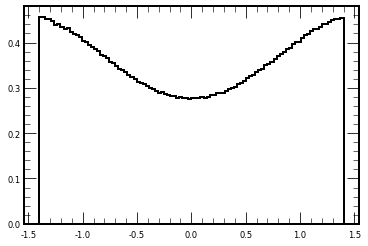

In [38]:
# Create datasets (skip down to make workspace if you've already created histogram file!)

datas_qcd = {}
datas_sig = {}

datas_qcd_rejected = {}
datas_sig_rejected = {}


for xs in xsecs:
    
    # Input files
#     path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_113/{}/xsec_{}/'.format(signal,xs)
#     if xs == 0 and signal == "sig_GtoWW35naReco":
#         path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_113/{}/xsec_{}/loss_rk5_05/'.format(signal,xs)
#         path= '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/QR_models/envelope/fitted_selections/run_113/xsec_0/loss_rk5_05/param5/'
    # open QCD
    path = 'fitted_qr/xs{}/'.format(int(xs))
    with h5py.File(path+'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_reco.h5', 'r') as f_qcd:
        print("Opening {}".format(path+'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_reco.h5'))
        
        # Get all features as numpy arrays and apply dEta cut
        qcd_tot = np.array(f_qcd.get("eventFeatures"))
        qcd_tot = qcd_tot[abs(qcd_tot[:,deta_idx]) < 1.40]
        qcd = np.copy(qcd_tot)
        datas_qcd_acc = {}
        plt.hist(qcd_tot[:,deta_idx],bins=100,histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True,density=True)
  
        #Define the main templates as the 'unused quantile' at 90-100% background efficiency
        datas_qcd_acc[1.0] = qcd_tot[qcd_tot[:,columns[0.9]] == 0]
        datas_qcd_acc[1.0] = datas_qcd_acc[1.0][:,mjj_idx]
        
        # DEFINE ORTHOGONAL QUANTILES
        for key in sorted(columns.keys()):
            
            # Start with q=0.01 and take all events that pass cut on VAE
            datas_qcd_acc[key] = qcd[qcd[:,columns[key]] == 1]
            datas_qcd_acc[key] = datas_qcd_acc[key][:,mjj_idx]
            
            #Remove those events from dataset and continue to next quantile
            qcd = qcd[qcd[:,columns[key]] == 0]
        
        datas_qcd[xs] = datas_qcd_acc
        

    # Open signal, repeat    
    with h5py.File(path+signal+'_reco.h5', 'r') as f_sig:
        print("Opening {}".format(path+signal+'_reco.h5'))
        
        sig_tot = np.array(f_sig.get("eventFeatures"))
        sig_tot = sig_tot[abs(sig_tot[:,deta_idx]) < 1.40]
    
    sig = np.copy(sig_tot)
    
    datas_sig_acc = {}
    datas_sig_acc[1.0] = sig_tot[sig_tot[:,columns[0.9]] == 0]
    datas_sig_acc[1.0] = datas_sig_acc[1.0][:,mjj_idx]
    
    for key in sorted(columns.keys()):
        
        datas_sig_acc[key] = sig[sig[:,columns[key]] == 1]
        datas_sig_acc[key] = datas_sig_acc[key][:,mjj_idx]

        sig = sig[sig[:,columns[key]] == 0]

    datas_sig[xs] = datas_sig_acc
    
    # Sanity checks
    #Check that sum of orthogonal quantiles yield total
    print('N total data events = {}'.format(qcd_tot.shape[0]))
    sum_quantiles = 0
    for i,key in enumerate(sorted(datas_qcd_acc.keys())):
        sum_quantiles += datas_qcd_acc[key].shape[0]
    print('Sum of all events = {}'.format(sum_quantiles))

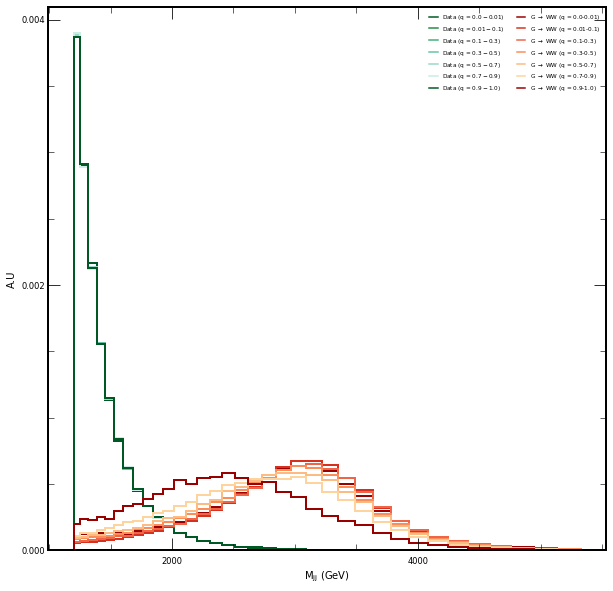

In [39]:
#Some quick control plots to check shapes
#Color style
scol = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'] *3
scol.reverse()
bcol = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824'] *3
bcol.reverse()

from matplotlib.lines import Line2D
import cmsstyle
fig, ax = plt.subplots(figsize=(10,10))

for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_qcd_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_qcd_acc[key],bins=bin_edges,label=r'Data (q = ${}-{}$)'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=bcol[i],fill=True,density=True)
      
for i,key in enumerate(sorted(datas_sig_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_sig_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_sig_acc[key],bins=bin_edges,label=r'G $\rightarrow$ WW (q = {}-{})'.format(lower_bound,key),histtype='step', linewidth=2, facecolor='none', edgecolor=scol[i],fill=True,density=True)
    
# plt.hist(sig_all,bins=bin_edges,label=r'G $\rightarrow$ WW all',histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True,density=True)
# plt.hist(sig_template,bins=bin_edges,label=r'G $\rightarrow$ WW rejected',histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True,density=True)
# plt.hist(qcd_all,bins=bin_edges,histtype='step', linewidth=2,linestyle="dashed",  facecolor='none', edgecolor='Black',fill=True,density=True)
# plt.hist(qcd_template,bins=bin_edges,histtype='step', linewidth=2, facecolor='none', edgecolor='Black',fill=True,density=True)
    
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor(),linestyle=h.get_linestyle()) for h in handles]
plt.ylabel('A.U')
plt.xlabel(u'$M_{jj}$ (GeV)')
plt.locator_params(nbins=4)
plt.legend(handles=new_handles, labels=labels,loc='best',frameon=False, ncol=2,fontsize='xx-small')
plt.savefig('signal_shapes_nolog_{}.pdf'.format(signal))

In [40]:
# Fill histograms

scaled_histos_qcd = {}
scaled_histos_data = {}
scaled_histos_signal = {}

# scaled_histos_qcd_rej = {}
# scaled_histos_data_rej = {}
# scaled_histos_signal_rej = {}
    
for ii,xs in enumerate(xsecs):
    
    print("\nxs = {}:".format(xs))
    
    datas_qcd_acc = datas_qcd[xs]  
    datas_sig_acc = datas_sig[xs] 
    
#     datas_qcd_rej = datas_qcd_rejected[xs] 
#     datas_sig_rej = datas_sig_rejected[xs] 
    
    histos_qcd = {}
    histos_data = {}
    histos_signal = {}
    histos_signal_pd = {}
    
#     histos_qcd_rej = {}
#     histos_data_rej = {}
#     histos_signal_rej = {}
    
    axis_title = ['M_{jj}','Events']
    scol =['#fc9272','#de2d26','#fee0d2']*2
    bcol =['#3182bd','#9ecae1','#deebf7']*2
    
    for i,(keyD,keyS) in enumerate(zip( sorted(datas_qcd_acc.keys()), sorted(datas_sig_acc.keys()) )):
        
        print("q = {}:".format(keyD))
            
        histos_qcd[keyD]  = rt.TH1D('data_obs_{}'.format(keyD),'',n_bins,bin_edges.astype('float'))
        histos_signal[keyS]= rt.TH1D('signal_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))
        histos_signal_pd[keyS]= rt.TH1D('signal_pd_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))
        rtnp.fill_hist(histos_qcd[keyD]   , datas_qcd_acc[keyD], weights=None)
        rtnp.fill_hist(histos_signal[keyS] , datas_sig_acc[keyS], weights=None)

        # Scale signal by the crossection injected (default is 10 fb)
        if xs == 0:
            scale = 1.
        else:
            scale = xs/10.
        print("Signal before scaling = {}".format(histos_signal[keyS].Integral()))
        histos_signal[keyS].Scale(scale_sig*scale)
        print("Signal after scaling = {}".format(histos_signal[keyS].Integral()))
        histos_qcd[keyD]  .SetStats(0)
        histos_signal[keyS].SetStats(0)

        histos_qcd[keyD].Sumw2()
        histos_signal[keyS].Sumw2()
        
        rdm = rt.TRandom3(0)
        for i in range (0,histos_signal[keyS].GetNbinsX()):
            n = histos_signal[keyS].GetBinContent(i+1)  
            n_rdm = rdm.Poisson(n)
            histos_signal_pd[keyS].SetBinContent(i+1,n_rdm)
            histos_signal_pd[keyS].SetBinError(i+1,n_rdm**0.5)
        print("Signal after pseudodata = {}".format(histos_signal_pd[keyS].Integral()))
        
        

    

        histos_qcd[keyD].SetXTitle(axis_title[0])
        histos_qcd[keyD].SetYTitle(axis_title[1])
        histos_qcd[keyD].binning = bin_edges

        histos_signal[keyS].SetXTitle(axis_title[0])
        histos_signal[keyS].SetYTitle(axis_title[1])
        histos_signal[keyS].binning = bin_edges

        histos_qcd[keyD].SetLineColor(rt.TColor.GetColor(bcol[ii]))
        histos_qcd[keyD].SetMarkerColor(rt.TColor.GetColor(bcol[ii]))
        histos_qcd[keyD].SetLineStyle(1)
        histos_qcd[keyD].SetLineWidth(2)
        
        histos_signal[keyS].SetLineColor(rt.TColor.GetColor(scol[ii]))
        histos_signal[keyS].SetLineStyle(1)
        histos_signal[keyS].SetLineWidth(2)
        histos_signal[keyS].SetFillColorAlpha((rt.TColor.GetColor(scol[ii])), 0.30)

        histos_signal_pd[keyS].SetLineColor(rt.TColor.GetColor(scol[ii]))
        histos_signal_pd[keyS].SetLineStyle(3)
        histos_signal_pd[keyS].SetLineWidth(2)
        histos_signal_pd[keyS].SetFillColorAlpha((rt.TColor.GetColor(scol[ii])), 0.50)

        c = rt.TCanvas("signal PD", "", 1000, 1000)
        histos_signal_pd[keyS].Draw('HIST')
        histos_signal[keyS].Draw('HISTsame')
        c.SaveAs("signalPD_{}{}.pdf".format(xs,keyD))
        
        histos_qcd[keyD].SetMarkerStyle(20)
        histos_qcd[keyD].SetMarkerSize(0.9)
        
        #Define signal Mjj window as 20% of each side of MX. Only used for drawing purposes and S/sqrt(B) values
        axis = histos_qcd[keyD].GetXaxis()
        bmin = axis.FindBin(3500*0.8)
        bmax  = axis.FindBin(3500*1.2)
        mjjmin = axis.GetBinCenter(bmin)
        mjjmax = axis.GetBinCenter(bmax)
        
                
        NQCD       = int(histos_qcd[keyD].Integral())
        NSIG       = int(histos_signal[keyS].Integral())
        SB         = NSIG/(NQCD**0.5)
        
        NQCD_SLICE = int(histos_qcd[keyD].Integral(bmin,bmax))
        NSIG_SLICE = int(histos_signal[keyS].Integral(bmin,bmax))
        SB_SLICE   = NSIG_SLICE/(NQCD_SLICE**0.5)
        
       
        print("N_SIG = {} N_BKG = {}".format(NSIG,NQCD))
        print("S/sqrt(B)={} For mX+-20%: S/sqrt(B)={}".format(SB,SB_SLICE))
        print("")

        
        NQCD       = int(histos_qcd[keyD].Integral())
        NSIG       = int(histos_signal[keyS].Integral())
        SB         = NSIG/np.sqrt(NQCD)
        

        # Make the pseudodataset with signal+data. 
        histos_data[keyD] = histos_qcd[keyD].Clone('data_{}_{}'.format(xs,keyD))
#         hIn = histos_qcd[keyD].Clone('dataIn_{}_{}'.format(xs,keyD))
        if xs != 0:
            histos_data[keyD].Add(histos_signal_pd[keyS])
#             rdm = rt.TRandom3(0)
#             for i in range (0,hIn.GetNbinsX()):
#                             n = hIn.GetBinContent(i+1)  
#                             n_rdm = rdm.Poisson(n)
#                             histos_data[keyD].SetBinContent(i+1,n_rdm)
#                             histos_data[keyD].SetBinError(i+1,n_rdm**0.5)

        histos_data[keyD].SetBinErrorOption(rt.TH1.kPoisson)
        
        print("Integrals: QCD = {} Signal = {} Pseudodata = {}".format(histos_qcd[keyD].Integral(),histos_signal[keyS].Integral(),histos_data[keyD].Integral()))
        print("")
                                  
    
    scaled_histos_data[xs]   = histos_data
    scaled_histos_qcd[xs]    = histos_qcd
    scaled_histos_signal[xs] = histos_signal   
     


xs = 0:
q = 0.01:
Signal before scaling = 16680.0
Signal after scaling = 8.7831452356
Signal after pseudodata = 9.0
N_SIG = 8 N_BKG = 76819
S/sqrt(B)=0.0288639432706 For mX+-20%: S/sqrt(B)=0.226107815823

Integrals: QCD = 76819.0 Signal = 8.7831452356 Pseudodata = 76819.0

q = 0.1:
Signal before scaling = 114962.0
Signal after scaling = 60.5352483558
Signal after pseudodata = 71.0
N_SIG = 60 N_BKG = 690432
S/sqrt(B)=0.0722089108598 For mX+-20%: S/sqrt(B)=0.577983954233

Integrals: QCD = 690432.0 Signal = 60.5352483558 Pseudodata = 690432.0

q = 0.3:
Signal before scaling = 149784.0
Signal after scaling = 78.8713804538
Signal after pseudodata = 64.0
N_SIG = 78 N_BKG = 1533163
S/sqrt(B)=0.0629941815539 For mX+-20%: S/sqrt(B)=0.500525828325

Integrals: QCD = 1533163.0 Signal = 78.8713804538 Pseudodata = 1533163.0

q = 0.5:
Signal before scaling = 87155.0
Signal after scaling = 45.8929869909
Signal after pseudodata = 50.0
N_SIG = 45 N_BKG = 1536259
S/sqrt(B)=0.0363061580313 For mX+-20%: S

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: signal PD
Info in <TCanvas::Print>: pdf file signalPD_00.01.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: signal PD
Info in <TCanvas::Print>: pdf file signalPD_00.1.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: signal PD
Info in <TCanvas::Print>: pdf file signalPD_00.3.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: signal PD
Info in <TCanvas::Print>: pdf file signalPD_00.5.pdf has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::

In [41]:
import cmsstyle #mplhep for Python2 cheatsheet

def drawHistos(qPass,qFail,scaled_histos_data,scaled_histos_signal, xsecs):
    c_out = rt.TCanvas("ratio_qacc{}_qrej{}".format(qPass,qFail), "", 1000, 1000)
    pad1 = rt.TPad("pad1_qacc{}_qrej{}".format(qPass,qFail), "pad1_qacc{}_qrej{}".format(qPass,qFail), 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.001)
    pad1.SetLeftMargin(0.13)
    # pad1.SetGridx()
    pad1.Draw()
    pad1.cd()
    leg = rt.TLegend(0.22, 0.6, 0.89, 0.90)
    leg.SetNColumns(2)
    leg.SetTextSize(0.045)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)

#     scaled_histos_data_rej[0][qFail].Draw('PEZ')
#     scaled_histos_data_rej[10][qFail].Draw('PEZsame')
#     scaled_histos_data_rej[100][qFail].Draw('PEZsame')

    scaled_histos_data[xsecs[0]][qFail].Draw('HIST')
    for xs in xsecs:
        scaled_histos_data[xs][qFail].Draw('HISTsame')
        scaled_histos_data[xs][qPass].Draw('PEZsame')
        scaled_histos_signal[xs][qPass].Draw('HISTsame')


    scaled_histos_data[xsecs[0]][qFail].SetTitle("")
    scaled_histos_data[xsecs[0]][qFail].SetMinimum(0.9)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetTitleSize(0.05)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetLabelSize(0.05)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetTitleOffset(0.95)
    scaled_histos_data[xsecs[0]][qFail].SetMaximum(qcd_tot.shape[0]*1.2)
    scaled_histos_data[xsecs[0]][qFail].GetYaxis().SetNdivisions(304)
    
    for xs in xsecs:
        leg.AddEntry(scaled_histos_data[xs][qPass] , 'Inj. {} fb:     Data q = {}'.format(int(xs),qPass), 'lep') 
        leg.AddEntry(scaled_histos_data[xs][qFail] , 'q = {}'.format('0.9-1.0'), 'l')
        leg.AddEntry(scaled_histos_signal[xs][0.1] , 'G(#sigma = {} fb)'.format(int(xs)), 'l') 


    leg.Draw('same')

    pad1.SetLogy()
    pad1.SetTitle('')
    pad1.Update()
    c_out.cd()
    pad2 = rt.TPad("pad2_qacc{}_qrej{}".format(qPass,qFail), "pad2_qacc{}_qrej{}".format(qPass,qFail), 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.00)
    pad2.SetBottomMargin(0.27)
    pad2.SetLeftMargin(0.13)
    # pad2.SetGrid()
    pad2.Draw()
    pad2.cd()
    data_hist_ratio = {}
    tline = {}
    for xs in xsecs:
        data_hist_ratio[xs] = scaled_histos_data[xs][qPass].Clone('data_hist_ratio_{}'.format(i))
        data_hist_ratio[xs].Divide( scaled_histos_data[xs][qFail])
    #     data_hist_ratio[xs].Scale( scaled_histos_data_rej[xs][qFail].Integral()/scaled_histos_data[xs][qPass].Integral())
        data_hist_ratio[xs].binning = bin_edges
        if xs == 0:
            data_hist_ratio[xs].SetTitle('')
            data_hist_ratio[xs].Draw('pez')
            eff = scaled_histos_data[xs][qPass].Integral()/scaled_histos_data[xs][qFail].Integral()
            data_hist_ratio[xs].SetMaximum(eff*1.5)
            data_hist_ratio[xs].SetMinimum(eff*0.5)
#             data_hist_ratio[xs].SetYTitle('#frac{#epsilon#timesq}{q_{0.9-1.0}}')
            data_hist_ratio[xs].SetYTitle('#frac{Acc.}{Rej.}')
            data_hist_ratio[xs].GetYaxis().CenterTitle()
            data_hist_ratio[xs].SetXTitle('M_{jj} (GeV)')
            data_hist_ratio[xs].GetYaxis().SetTitleOffset(0.4)
            data_hist_ratio[xs].GetYaxis().SetTitleSize(0.12)
            data_hist_ratio[xs].GetYaxis().SetLabelSize(0.12)
            data_hist_ratio[xs].GetYaxis().SetNdivisions(304)
            data_hist_ratio[xs].GetXaxis().SetNdivisions(909)
            data_hist_ratio[xs].GetXaxis().SetTitleOffset(0.95)
            data_hist_ratio[xs].GetXaxis().SetTitleSize(0.12)
            data_hist_ratio[xs].GetXaxis().SetLabelSize(0.12)
            data_hist_ratio[xs].GetXaxis().SetTickSize(0.07)
        else:
            data_hist_ratio[xs].Draw('pez same')


    #     tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
        
        tline[xs] = rt.TLine(min_bin, eff, max_bin, eff)
        tline[xs].SetLineColor(rt.kBlack)
        tline[xs].SetLineStyle(rt.kDashed)
        tline[xs].Draw('same')
    pad2.Update()
    c_out.Update()
    c_out.SaveAs("mjj_q{}_{}.pdf".format(qPass,signal))
    return c_out, leg, tline[0], data_hist_ratio

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.01_qrej1.0
Info in <TCanvas::Print>: pdf file mjj_q0.01_RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.1_qrej1.0
Info in <TCanvas::Print>: pdf file mjj_q0.1_RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.3_qrej1.0
Info in <TCanvas::Print>: pdf file mjj_q0.3_RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.5_qrej1.0
Info in <TCanvas::Print>: pdf file mjj_q0.5_RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio_qacc0.7_qrej1.0
Info in <TCanvas::Print>: pdf file mjj_q0.7_RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV.pdf has been created
Warning in <TCanvas::Constructor>: Del

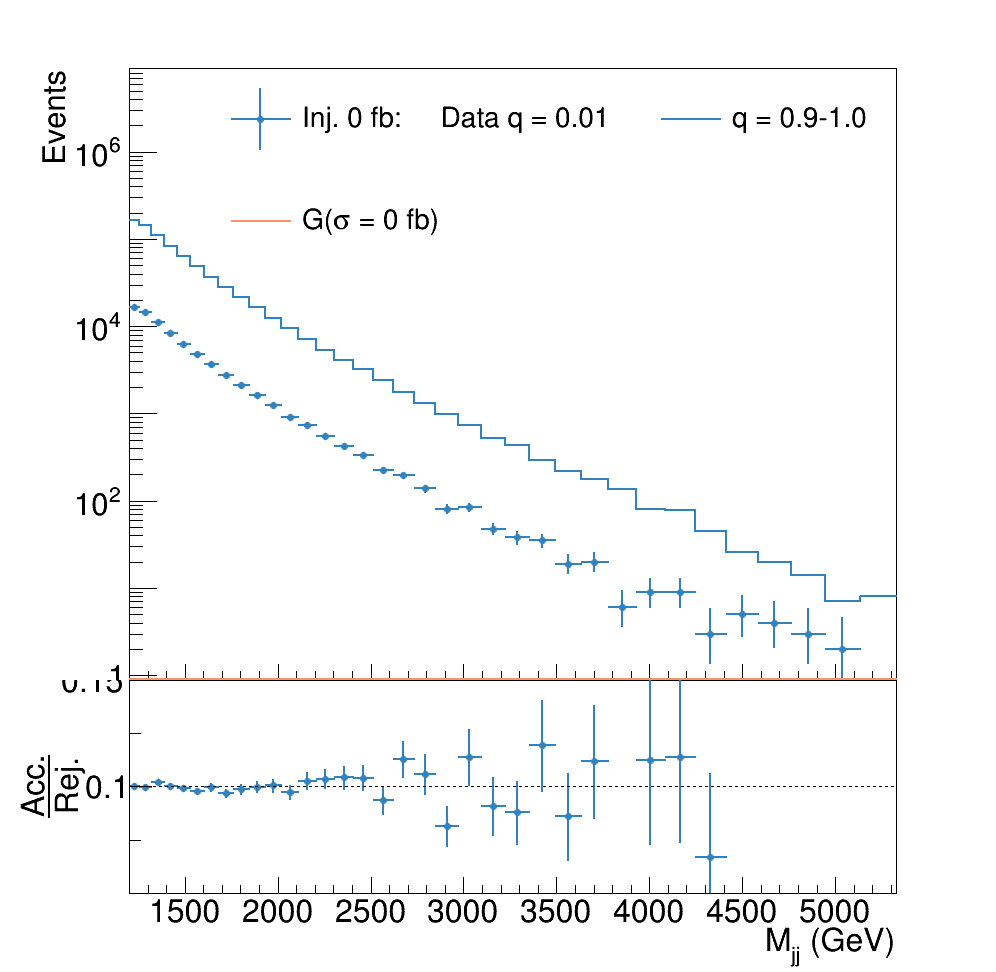

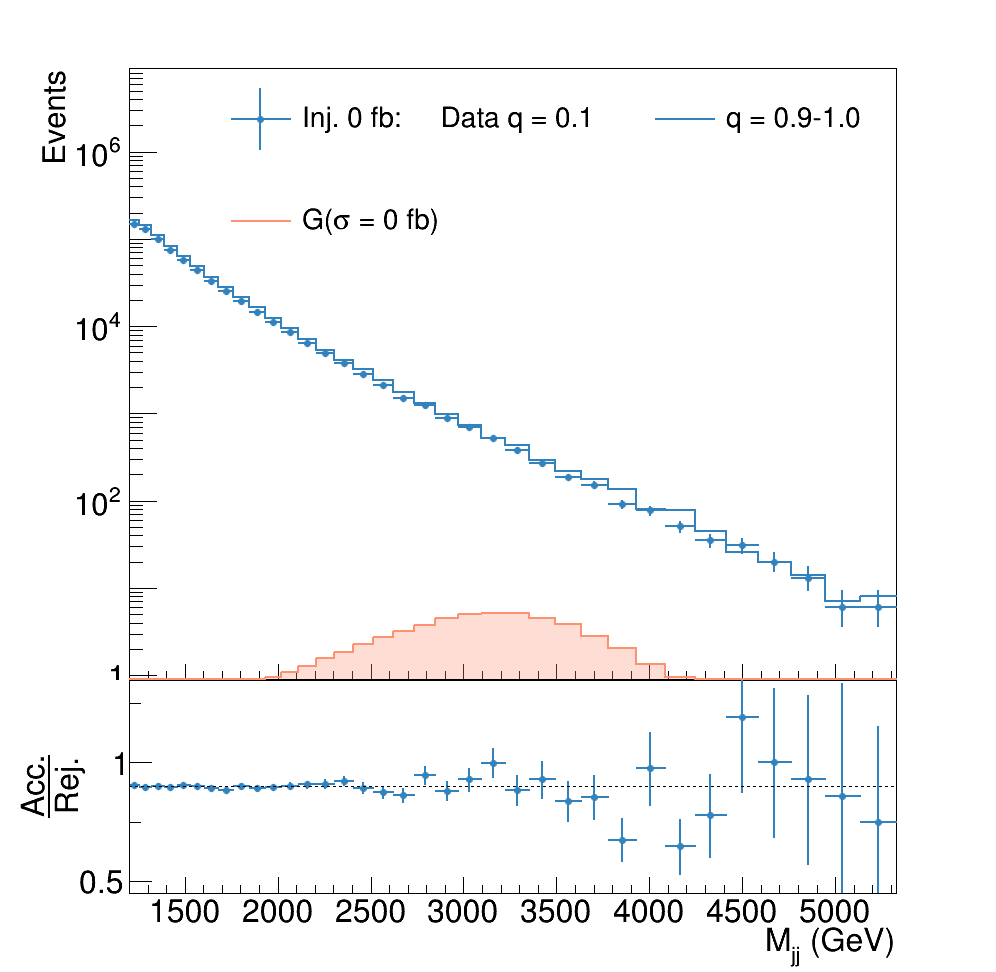

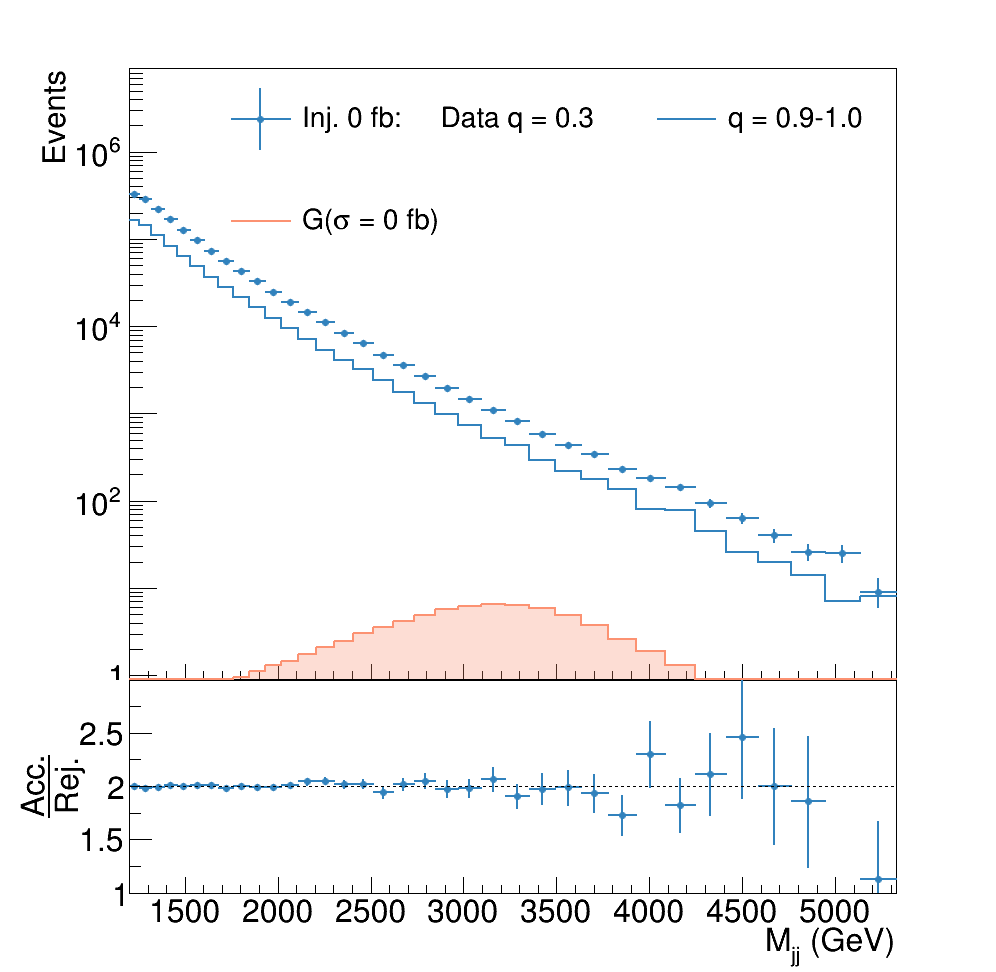

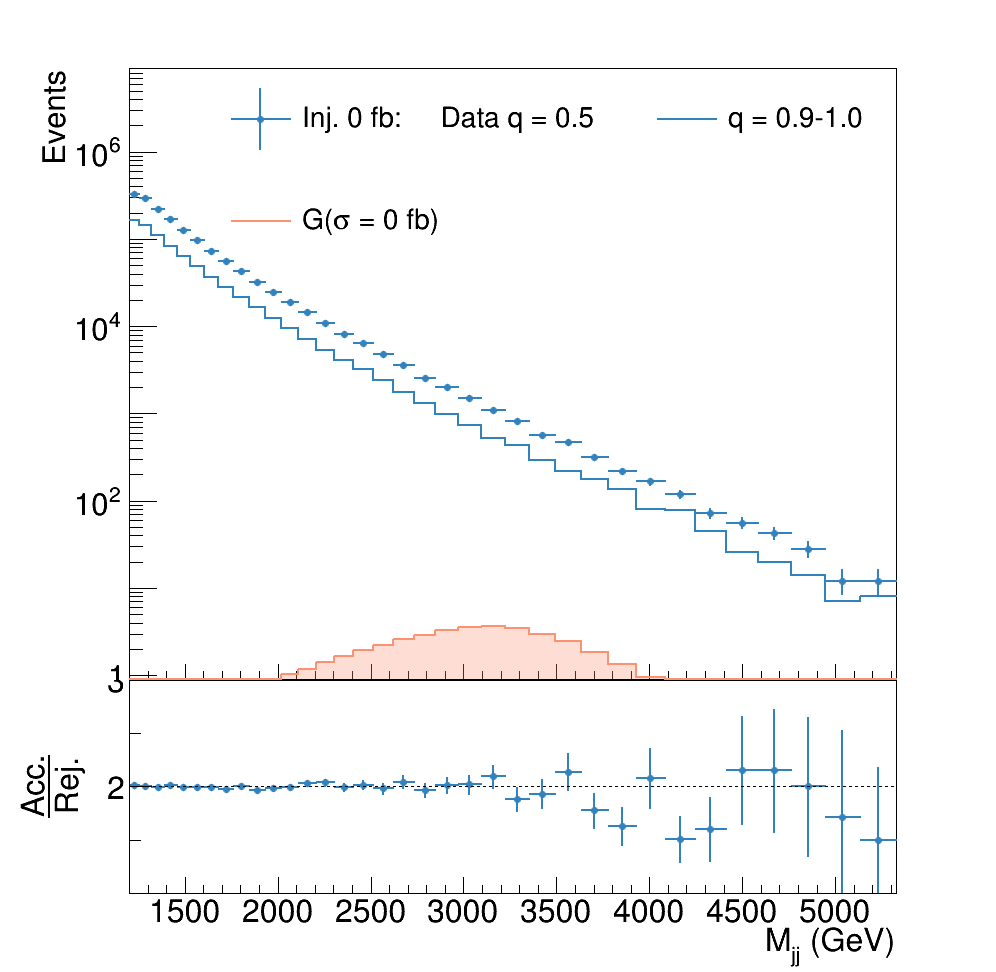

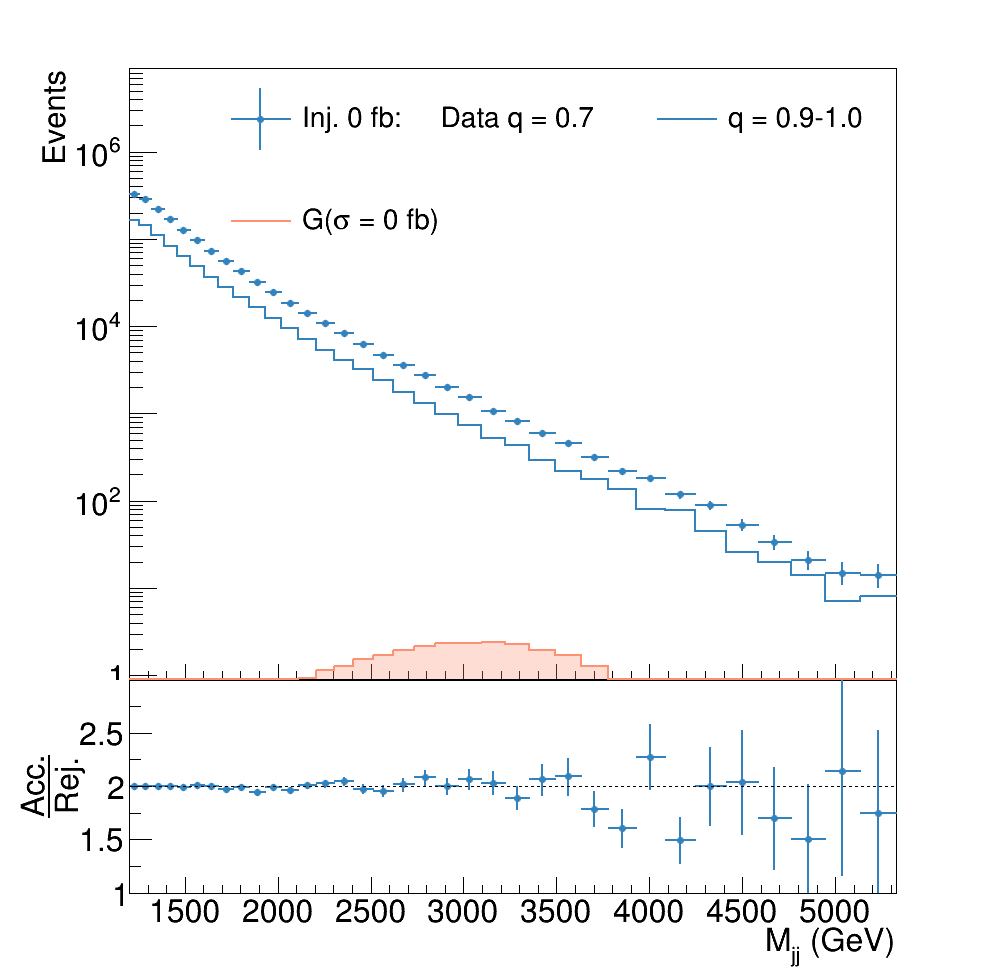

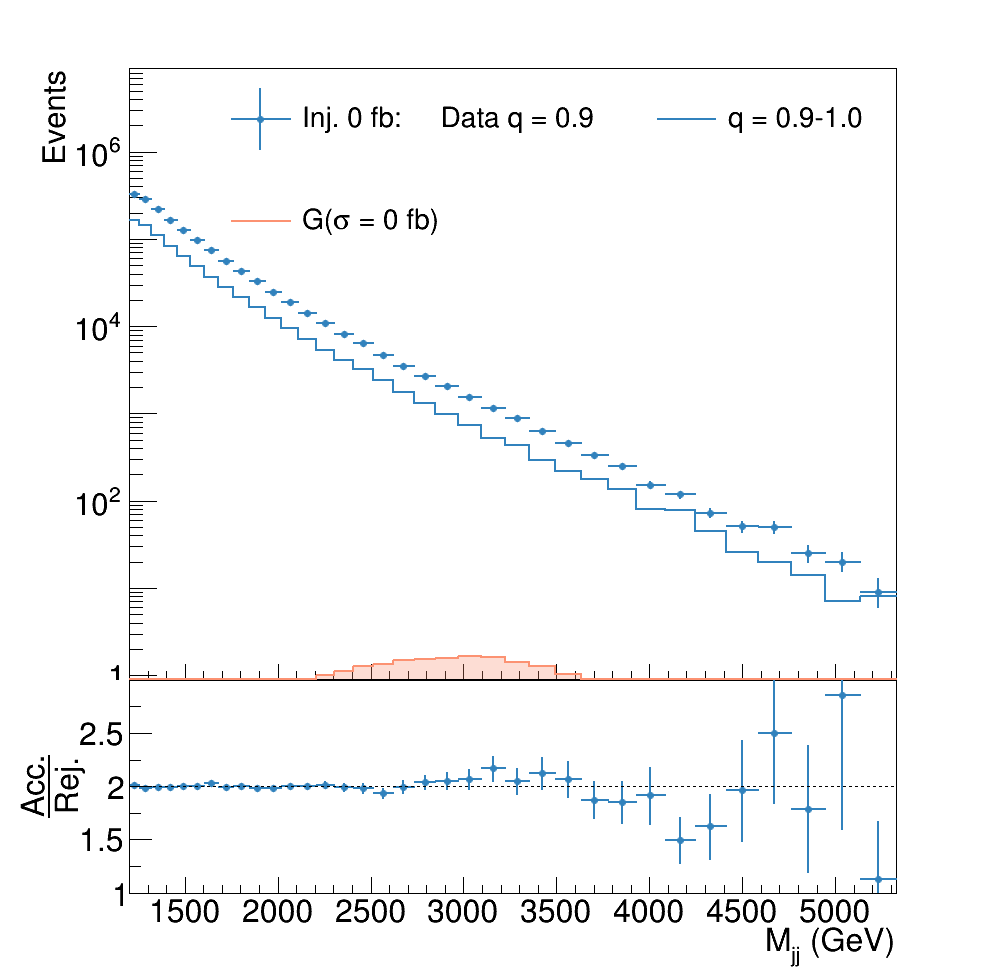

In [42]:
canvs = []
c0,l0,t0,h0 = drawHistos(0.01,1.0,scaled_histos_data,scaled_histos_signal,xsecs); canvs.append([c0,l0,t0,h0]);canvs[0][0].Draw()
c1,l1,t1,h1 = drawHistos(0.1 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c1,l1,t1,h1]);canvs[1][0].Draw()
c2,l2,t2,h2 = drawHistos(0.3 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c2,l2,t2,h2]);canvs[2][0].Draw()
c3,l3,t3,h3 = drawHistos(0.5 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c3,l3,t3,h3]);canvs[3][0].Draw()
c4,l4,t4,h4 = drawHistos(0.7 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c4,l4,t4,h4]);canvs[4][0].Draw()
c5,l5,t5,h5 = drawHistos(0.9 ,1.0,scaled_histos_data,scaled_histos_signal,xsecs) ; canvs.append([c5,l5,t5,h5]);canvs[5][0].Draw()

0.9
0.500389403785
1
0.7
0.500922189638
0.5
0.499782914209
0.3
0.500792153215
0.1
1.11205158509
0.01
9.99487106054
0.01
0.1
0.3
0.5
0.7
0.9


Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already

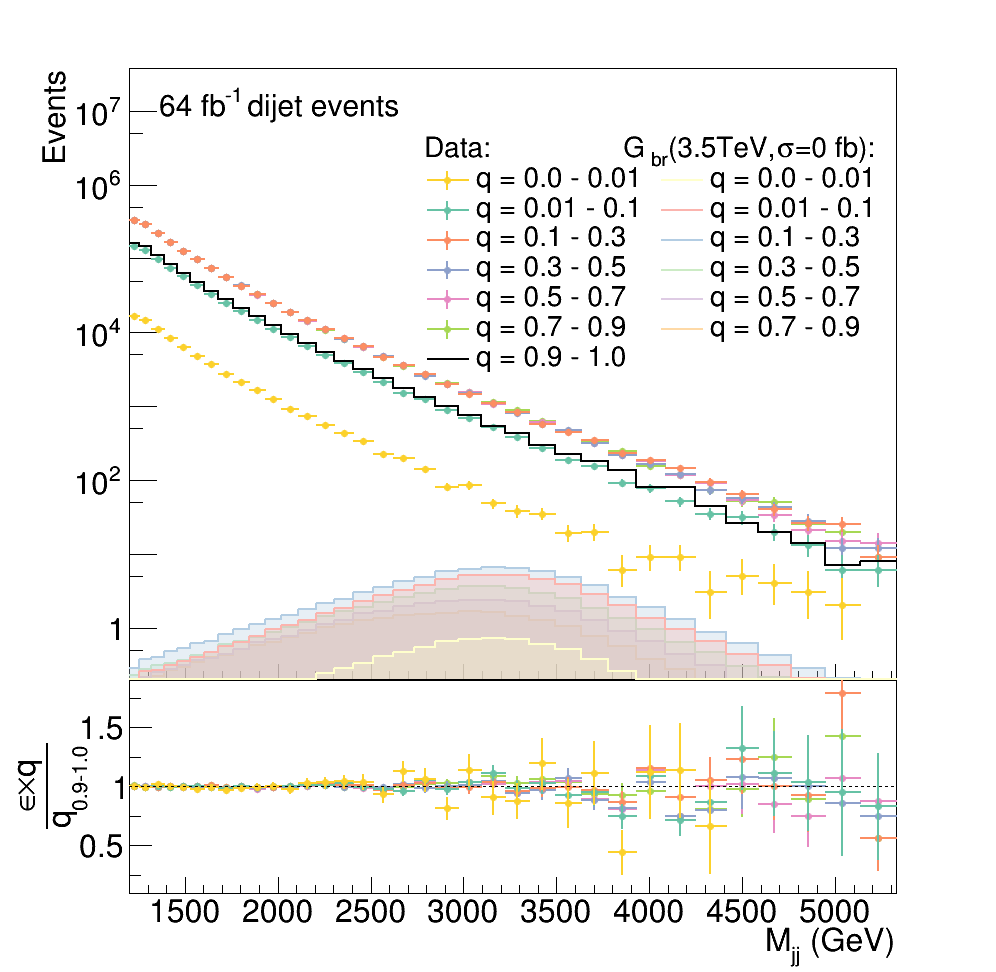

In [43]:
# Draw "nice" ratio plot for paper, check efficiency quantile/template and smoothness

xs = 0
import cmsstyle #mplhep for Python2 cheatsheet
#Color style
scol = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc'] *3
scol.reverse()
bcol = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f'] *3
bcol.reverse()

c_out = rt.TCanvas("ratio", "", 1000, 1000)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
# pad1.SetGridx()
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.42, 0.45, 0.89, 0.80)
leg.SetNColumns(2)
leg.SetTextSize(0.045)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
scaled_histos_data[xs][1.0].SetLineColor(rt.kBlack)
scaled_histos_data[xs][1.0].SetMarkerColor(rt.kBlack)
scaled_histos_data[xs][1.0].Draw('HIST')
scaled_histos_data[xs][1.0].SetTitle("")
scaled_histos_data[xs][1.0].SetMinimum(0.2)
scaled_histos_data[xs][1.0].GetYaxis().SetTitleSize(0.05)
scaled_histos_data[xs][1.0].GetYaxis().SetLabelSize(0.05)
scaled_histos_data[xs][1.0].GetYaxis().SetTitleOffset(0.95)
scaled_histos_data[xs][1.0].SetMaximum(qcd_tot.shape[0]*5.0)
scaled_histos_data[xs][1.0].GetYaxis().SetNdivisions(304)
# background_hist_template.GetYaxis().SetLabelSize(0.05)
# background_hist_template.GetYaxis().SetTitleSize(0.05)
# signal_hist_template    .Draw('same HIST')
# leg.SetTextSize (0.03)
# leg.SetTextFont( 62 )
# leg.SetHeader('Data:                 G_{%s}(%.1fTeV,#sigma=10 fb)#rightarrowWW:'%(width[:2],mX))
leg.SetHeader('Data:                 G_{%s}(%.1fTeV,#sigma=%i fb):'%(width[:2],mX,xs))
# leg.SetTextSize (0.03)
# leg.SetTextFont( 42 )
for i,key in enumerate(sorted(scaled_histos_data[0].keys(), reverse=True)):
    if key == 1.0:
        continue
    scaled_histos_data[xs][key].SetLineColor(rt.TColor.GetColor(bcol[i]))
    scaled_histos_data[xs][key].SetMarkerColor(rt.TColor.GetColor(bcol[i]))
    scaled_histos_data[xs][key].Draw('pez same')
    scaled_histos_signal[xs][key].SetLineColor(rt.TColor.GetColor(scol[i]))
    scaled_histos_signal[xs][key].SetFillColorAlpha((rt.TColor.GetColor(scol[i])), 0.30)
    scaled_histos_signal[xs][key].Draw('HIST same')
for i,key in enumerate(sorted(scaled_histos_data[0].keys(), reverse=False)):
    if key == 1.0:
        continue
    elif i > 0:
        lower_bound = sorted(scaled_histos_data[xs].keys())[i-1]
    else:
       lower_bound = 0.0 
    leg.AddEntry(scaled_histos_data[xs][key]  , 'q = {} - {}'.format(lower_bound,key), 'lep')
    leg.AddEntry(scaled_histos_signal[xs][key], 'q = {} - {}'.format(lower_bound,key), 'l')    
scaled_histos_data[xs][1.0].Draw('same HIST')
# histos_signal_full[0.1].Draw('HIST same')
# histos_signal_full[0.01].Draw('HIST same')
# leg.SetTextSize(0.04)  
leg.AddEntry(scaled_histos_data[xs][1.0] , 'q = 0.9 - 1.0', 'l') 
leg.Draw('same')

pad1.SetLogy()
pad1.SetTitle('')

c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio = {}
tline = {}
for i,key in enumerate((sorted(scaled_histos_data[xs].keys(),reverse=True))):
    if key == 1.0:
        continue
    pad2.cd()
    if i > 0:
        lower_bound = sorted(scaled_histos_data[xs].keys())[i-1]
    else:
        lower_bound = 0.0 
    scaled_histos_data[0][key].Sumw2()
    data_hist_ratio[key] = scaled_histos_data[xs][key].Clone('data_hist_ratio_{}'.format(i))
    scaled_histos_data[0][1.0].Sumw2()
    data_hist_ratio[key].Divide(scaled_histos_data[xs][1.0])
    data_hist_ratio[key].Scale(scaled_histos_data[xs][1.0].Integral()/scaled_histos_data[xs][key].Integral())
    print(key)
    print(scaled_histos_data[xs][1.0].Integral()/scaled_histos_data[xs][key].Integral())
    data_hist_ratio[key].binning = bin_edges
    if i == 1:
        print(i)
        data_hist_ratio[key].SetTitle('')
        data_hist_ratio[key].Draw('pez')
        data_hist_ratio[key].SetMaximum(1.9)
        data_hist_ratio[key].SetMinimum(0.1)
        data_hist_ratio[key].SetYTitle('#frac{#epsilon#timesq}{q_{0.9-1.0}}')
#         data_hist_ratio[key].SetYTitle('#frac{q}{q_{0.9-1.0}}')
        data_hist_ratio[key].GetYaxis().CenterTitle()
        data_hist_ratio[key].SetXTitle('M_{jj} (GeV)')
        data_hist_ratio[key].GetYaxis().SetTitleOffset(0.4)
        data_hist_ratio[key].GetYaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetYaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetYaxis().SetNdivisions(304)
        data_hist_ratio[key].GetXaxis().SetNdivisions(909)
        data_hist_ratio[key].GetXaxis().SetTitleOffset(0.95)
        data_hist_ratio[key].GetXaxis().SetTitleSize(0.12)
        data_hist_ratio[key].GetXaxis().SetLabelSize(0.12)
        data_hist_ratio[key].GetXaxis().SetTickSize(0.07)
    else:
        data_hist_ratio[key].Draw('pez same')
    
    
#     tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
#     tline[key].SetLineColor(rt.TColor.GetColor(bcol[i]))
    tline[key] = rt.TLine(min_bin, 1.0, max_bin, 1.0)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')
for i,key in enumerate(sorted(data_hist_ratio.keys())):
    print(key)
# sig_hist_ratio = signal_hist_acc.Clone('signal_hist_ratio')
# sig_hist_ratio.SetTitle('')
# sig_hist_ratio.Sumw2()
# sig_hist_ratio.Divide(signal_hist_rej)
# sig_hist_ratio.binning = bin_edges
# data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())

# sig_hist_ratio.Draw('pez same')
c_out.cd()
latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.033)
latex.SetTextFont( 42 )
latex.DrawLatex (0.16 ,0.88 , "%.0f fb^{-1} dijet events"%lumi)
if xs != 0:
    latex.SetTextSize (0.03)
    latex.SetTextFont( 42 )
    latex.DrawLatex(0.16 ,0.83 , "Inj. {} fb @ 3.5 TeV".format(int(xs)))
# latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1.2 TeV")
# latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
c_out.SaveAs('mjj_all_inj{}fb_{}.pdf'.format(int(xs),signal))

In [44]:
# Make sure the data is correctly created and store all histograms to file (will be imported to workspace below)

outfile = rt.TFile("histograms_{}.root".format(tag), 'RECREATE' )

for xs in xsecs:
    print("\nFor xsec={}:".format(xs) )
    scaled_histos_signal[xs][1.0].Write('signal_acc_{}fb_q{}p'.format(xs,100))   
    scaled_histos_data[xs][1.0].Write('data_acc_{}fb_q{}p'.format(xs,100))
    for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
#         print('SIG PASS = {} SIG FAIL = {} BKG PASS = {} BKG FAIL = {}'.format( scaled_histos_signal[xs][key].Integral(),scaled_histos_signal_rej[xs][key].Integral(), scaled_histos_data[xs][key].Integral(),scaled_histos_data_rej[xs][key].Integral()))
        scaled_histos_signal[xs][key].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))
#         scaled_histos_signal_rej[xs][key].Write('signal_rej_{}fb_q{}p'.format(xs,quantile))
        
        scaled_histos_data[xs][key].Write('data_acc_{}fb_q{}p'.format(xs,quantile))
#         scaled_histos_data_rej[xs][key].Write('data_rej_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 


For xsec=0:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9


Signal before scaling = 8.7831452356
Signal after scaling = 0.0
Signal after pseudodata = 0.0
Signal before scaling = 8.7831452356
Signal after scaling = 8.7831452356
Signal after pseudodata = 6.0
Signal before scaling = 8.7831452356
Signal after scaling = 17.5662904712
Signal after pseudodata = 8.0
Signal before scaling = 8.7831452356
Signal after scaling = 35.1325809424
Signal after pseudodata = 36.0
Signal before scaling = 8.7831452356
Signal after scaling = 52.6988714136
Signal after pseudodata = 57.0
Signal before scaling = 8.7831452356
Signal after scaling = 70.2651618848
Signal after pseudodata = 75.0
Signal before scaling = 8.7831452356
Signal after scaling = 87.831452356
Signal after pseudodata = 71.0
Signal before scaling = 60.5352483558
Signal after scaling = 0.0
Signal after pseudodata = 0.0
Signal before scaling = 60.5352483558
Signal after scaling = 60.5352483558
Signal after pseudodata = 70.0
Signal before scaling = 60.5352483558
Signal after scaling = 121.070496712
Sign

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already

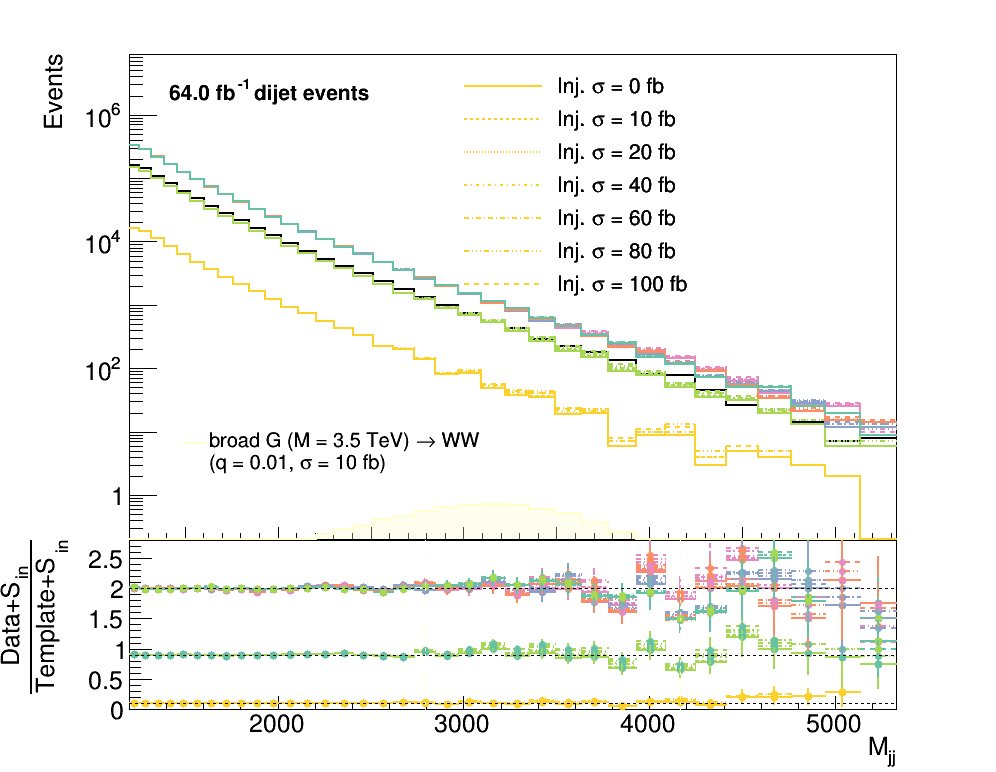

In [45]:
# Make data with injected signal using QR training assuming NO signal is present!
# Do some validation checks and plot data distribution with injected signal.
# Also make table with S/sqrt(B) over full dijet range and in mJJ window.

sig_inj_vals = [0,1,2,4,6,8,10]
MX = mX*1000 #Signal mass in units of GeV

data = {'q':[],'q_string':[],'sig_inj':[],'mjjmin':[],  'mjjmax':[], 'NQCD':[], 'NSIG':[],'SB':[],'NQCD_SLICE':[], 'NSIG_SLICE':[],'SB_SLICE':[]}
        
# These dictionaries will contain the 90-100% quantile with injected signal (data_hist_rej_inj_all)
# and the orthogonal quantiles with injected signal (data_hist_acc_inj_all). They will be saved to 'histfile'
# The format is data_hist_rej_inj_all[quantile][sig_injected]

data_hist_acc_inj_all = {}
signal_hist_acc_inj_all = {}

#Define signal Mjj window as 20% of each side of MX. Only used for drawing purposes and S/sqrt(B) values
axis = scaled_histos_data[0][1.0].GetXaxis()
bmin = axis.FindBin(MX*0.8)
bmax  = axis.FindBin(MX*1.2)
mjjmin = axis.GetBinCenter(bmin)
mjjmax = axis.GetBinCenter(bmax)

# Helper function to round numbers for TeX table
def round_sig(x, sig=1):
    if x == 0.:
        return 0
    else:
        return round(x, sig-int(floor(log10(abs(x))))-1)


leg = rt.TLegend(0.48, 0.5, 0.89, 0.85)
#stick to no injecion for now
c_out = rt.TCanvas("ratio", "", 1000, 800)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.001)
pad1.SetLeftMargin(0.13)
pad1.SetLogy()
pad1.SetTitle('')
pad1.Draw()
pad1.cd()
leg = rt.TLegend(0.45, 0.61, 0.89, 0.91)
# leg.SetNColumns(2)
leg.SetTextSize(0.05)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize (0.03)
leg.SetTextFont( 62 )
# leg.SetHeader('SR (#forall q):                  CR (q = 0.9 - 1.0):')
leg.SetTextSize (0.03)
leg.SetTextFont( 42 )
scaled_histos_data[0][1.0].Draw('HIST')
scaled_histos_signal[0][0.01].Draw('HISTsame')
scaled_histos_data[0][1.0].SetTitle("")
scaled_histos_data[0][1.0].SetMinimum(0.2)
scaled_histos_data[0][1.0].SetMaximum(qcd_tot.shape[0]*1.2)
scaled_histos_data[0][1.0].GetYaxis().SetLabelSize(0.05)
scaled_histos_data[0][1.0].GetYaxis().SetTitleSize(0.05)


for i,key in enumerate(sorted(scaled_histos_data[0].keys())):
    if i > 0:
        lower_bound = sorted(scaled_histos_data[0].keys())[i-1]
    else:
        lower_bound = 0.0 
#     if key == 1.0: #To skip reject quantile
#        continue
    prefix = 'q'+str(int(key*100))
#     print(prefix) 
#     print('Quantile integral = {}'.format(histos_data[key].Integral()))
#     print('Template integral = {} (10%efficiency)'.format(background_hist_template.Integral()))
#     print('Efficiency= {}'.format(histos_data[key].Integral()/background_hist_template.Integral()))
    
    data_hist_acc_inj = {}
    signal_hist_acc_inj = {}

    for k,sig_inj in enumerate(sig_inj_vals):
        data_hist_acc_inj[sig_inj] = scaled_histos_data[0][key].Clone('data_hist_acc_inj{}_{}'.format(sig_inj,prefix))
        signal_hist_acc_inj[sig_inj] = scaled_histos_signal[0][key].Clone('signal_inj{}_{}'.format(sig_inj,prefix))
        tmpSig = scaled_histos_signal[0][key].Clone('tmp_signal_inj{}_{}'.format(sig_inj,prefix))
        
        # Scale signal by the crossection injected (default is 10 fb)
        if xs == 0:
            scale = 1.
        else:
            scale = xs/10.
        print("Signal before scaling = {}".format(tmpSig.Integral()))
        tmpSig.Scale(sig_inj)
        print("Signal after scaling = {}".format(tmpSig.Integral()))
        
        data_hist_acc_inj[sig_inj].Sumw2()
        tmpSig.Sumw2()
        
        rdm = rt.TRandom3(0)
        for ii in range (0,tmpSig.GetNbinsX()):
            n = tmpSig.GetBinContent(ii+1)  
            n_rdm = rdm.Poisson(n)
            signal_hist_acc_inj[sig_inj].SetBinContent(ii+1,n_rdm)
            signal_hist_acc_inj[sig_inj].SetBinError(ii+1,n_rdm**0.5)
        print("Signal after pseudodata = {}".format(signal_hist_acc_inj[sig_inj].Integral()))
    
        # Make the pseudodataset with signal+data. 
        if sig_inj != 0:
            data_hist_acc_inj[sig_inj].Add(signal_hist_acc_inj[sig_inj])

        signal_hist_acc_inj[sig_inj].SetBinErrorOption(rt.TH1.kPoisson)
        
        
        # Compute some useful S/B quantities and print as latex table
        if sig_inj != 0:
            data['q'].append(key)
            keystring = '{} - {}'.format(lower_bound,key)
            data['q_string'].append(keystring)
            data['sig_inj'].append(int(sig_inj*10.))
            data['mjjmin'].append(mjjmin)
            data['mjjmax'].append(mjjmax)
            NQCD       = int(histos_data[key].Integral())
            NSIG       = int(data_hist_acc_inj[sig_inj].Integral())-int(scaled_histos_data[0][key].Integral())
            SB         = round_sig(NSIG/np.sqrt(NQCD))
            NQCD_SLICE = int(scaled_histos_data[0][key].Integral(bmin,bmax))
            NSIG_SLICE = int(data_hist_acc_inj[sig_inj].Integral(bmin,bmax))-int(scaled_histos_data[0][key].Integral(bmin,bmax))
            SB_SLICE   = round_sig(NSIG_SLICE/np.sqrt(NQCD_SLICE))
            data['NQCD'].append(NQCD)
            data['NSIG'].append(NSIG)
            data['SB'].append(SB)
            data['NQCD_SLICE'].append(NQCD_SLICE)
            data['NSIG_SLICE'].append(NSIG_SLICE)
            data['SB_SLICE'].append(SB_SLICE)
        if key != 1.0:
            data_hist_acc_inj[sig_inj].SetLineColor(rt.TColor.GetColor(bcol[i]))
            data_hist_acc_inj[sig_inj].SetLineStyle(k+1)
            data_hist_acc_inj[sig_inj].SetLineWidth(2)
            data_hist_acc_inj[sig_inj].Draw('sameHIST')
        if key == 0.01:
            leg.AddEntry(data_hist_acc_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
#             leg.AddEntry(data_hist_rej_inj[sig_inj],'Inj. #sigma = {} fb'.format(int(sig_inj*10.)),'l')
            
    data_hist_acc_inj_all[key] = data_hist_acc_inj
    signal_hist_acc_inj_all[key] = data_hist_acc_inj
    
dataP = pandas.DataFrame(data)
dataP.to_pickle('Yields.pkl')
print(dataP.to_latex(columns=['q_string','sig_inj','NQCD','NSIG','SB','NQCD_SLICE','NSIG_SLICE','SB_SLICE'],header=['q','$\sigma$ [fb]','$N_{bkg}$','$N_{sig}$','$S/\sqrt{B}$','$N_{bkg}$ ($M_{X} \pm 10\%$)','$N_{sig}$ ($M_{X} \pm 10\%$)','$S/\sqrt{B}$ ($M_{X} \pm 10\%$)'],index=False,escape=False)) 
leg2 = rt.TLegend(0.18, 0.12, 0.3, 0.2)
leg2.SetBorderSize(0)
leg2.SetFillStyle(0)
leg2.SetTextSize (0.04)
leg2.SetTextFont( 42 )
leg2.AddEntry(histos_signal[0.01],'{} G (M = {} TeV) #rightarrow WW'.format(width,mX),'l')
leg2.AddEntry(None,'(q = 0.01, #sigma = 10 fb)','')
leg2.Draw('same')
c_out.Update()


# Add ratio SRinj/CRinj
c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.00)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_ratio_all = {}
tline = {}
for i,key in enumerate(sorted(histos_data.keys())):
    if key == 1.0:
        continue
    data_hist_ratio = {}
    pad2.cd()
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
        lower_bound = 0.0 
    
    for k,sig_inj in enumerate(sig_inj_vals):
        
        data_hist_ratio[sig_inj] = data_hist_acc_inj_all[key][sig_inj].Clone('data_hist_ratio_{}{}'.format(i,k))
        data_hist_ratio[sig_inj].Divide(data_hist_acc_inj_all[1.0][sig_inj])
        data_hist_ratio[sig_inj].binning = bin_edges

        if k == 0 and i == 0:
            data_hist_ratio[sig_inj].SetTitle('')
            data_hist_ratio[sig_inj].Draw('pez')
            data_hist_ratio[sig_inj].SetMaximum(2.8)
            data_hist_ratio[sig_inj].SetMinimum(0.0)
            data_hist_ratio[sig_inj].SetYTitle('#frac{Data+S_{in}}{Template+S_{in}}')
            data_hist_ratio[sig_inj].GetYaxis().SetTitleOffset(0.5)
            data_hist_ratio[sig_inj].GetYaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetYaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetNdivisions(506)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleOffset(0.95)
            data_hist_ratio[sig_inj].GetXaxis().SetTitleSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetLabelSize(0.12)
            data_hist_ratio[sig_inj].GetXaxis().SetTickSize(0.07)
        else:
            data_hist_ratio[sig_inj].Draw('pez same')
    
    data_hist_ratio_all[key] = data_hist_ratio
    
    tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
    tline[key].SetLineColor(rt.kBlack)
    tline[key].SetLineStyle(rt.kDashed)
    tline[key].Draw('same')

vlineDown = rt.TLine(mjjmin, 0.0, mjjmin, 2.8)
vlineDown.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineDown.SetLineStyle(rt.kDashed)
vlineDown.Draw('same')
vlineUp = rt.TLine(mjjmax, 0.0, mjjmax, 2.8)
vlineUp.SetLineColor(rt.TColor.GetColor(scol[0]))
vlineUp.SetLineStyle(rt.kDashed)
vlineUp.Draw('same')
c_out.cd()


latex = rt.TLatex()
latex.SetNDC ()
latex.SetTextSize (0.03)
latex.SetTextFont( 62 )
latex.DrawLatex (0.17 ,0.87 , "%.1f fb^{-1} dijet events"%lumi)
latex.SetTextSize (0.03)
latex.SetTextFont( 42 )
# latex.DrawLatex(0.17 ,0.83 , "#Delta#eta_{jj} < 1.3, M_{jj} > 1246 GeV")
# latex.DrawLatex(0.17 ,0.79 , "p_{T} > 200 GeV, |#eta| < 2.5")
c_out.Update()
c_out.Draw()
leg.Draw('same')
c_out.SaveAs('sigInj_all_{}.pdf'.format(signal))


leg.Draw('same')
c_out.Draw()   

In [27]:
# Make one file for shortcut-data

sig_inj_vals = [0,1,2,4,6,8,10]

outfile = rt.TFile("histograms_injSig_{}.root".format(tag), 'RECREATE' )

for si in sig_inj_vals:
    xs = 10*si
    print("\nFor xsec={}:".format(xs) )
    signal_hist_acc_inj_all[1.0][si].Write('signal_acc_{}fb_q{}p'.format(xs,100))   
    data_hist_acc_inj_all[1.0][si].Write('data_acc_{}fb_q{}p'.format(xs,100))
    for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
        data_hist_acc_inj_all[key][si].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))
        signal_hist_acc_inj_all[key][si].Write('data_acc_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 


For xsec=0:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=10:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=20:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=40:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=60:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=80:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=100:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9


In [ ]:
# # THIS SEEMS TO FAIL DUE TO MEMORY! Run as python script instead gof_final.py

# def makeWS(data_rej,data_acc,signal_rej,signal_acc, outname,quantile,qr_unc_file=None):
  
#   efficiency = data_acc.Integral()/data_rej.Integral() #How much rej histogram needs to be scaled to match acc
#   print('Using efficiency = {} '.format(efficiency))
 
#   xaxis = data_acc.GetXaxis().GetXbins()
#   min_bin = xaxis[0]
#   max_bin = xaxis[len(xaxis)-1]
#   n_bins  = len(xaxis)-1
  
#   # set up workspace
#   datacard_ws = rt.TFile.Open(outname,'recreate')
#   w = rt.RooWorkspace('w','w')
#   x = rt.RooRealVar('x','x',min_bin,max_bin)
#   w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

#   acc_bin_functions = rt.RooArgList()
#   rej_bin_functions = rt.RooArgList()
  
#   # Name efficiency per quantile to allow for combination
#   w.factory('eff_%s[%f]'%(quantile,efficiency))
#   w.var('eff_%s'%quantile).setConstant(True)

  
#   empty_hist = rt.TH1D('empty_hist','empty_hist', data_rej.GetNbinsX(), data_rej.GetXaxis().GetXbins().GetArray())

#   for iBinX in range(1,data_rej.GetNbinsX()+1):
#       empty_hist.SetBinContent(iBinX,1)
#       rej_bin = data_rej.GetBinContent(iBinX)
#      # Name efficiency per quantile to allow for combination 
#       # w.factory('eff_%s_%i[%f,%f,%f]'%(quantile,iBinX,efficiency,efficiency*0.98,efficiency*1.02,))
# #       w.var('eff_%s_%i'%(quantile,iBinX)).setConstant(True)
      
#       # Uncertainty on yield in reject based on QR envelope: qr_rms/qr_cutValue
# #       rms_qr = qr_unc_file['q90'][iBinX-1][2]/qr_unc_file['q90'][iBinX-1][1]
# #       rms_qr = 0.064
# #       print('crBin%i_In[%.1f,%.1f,%.1f]'%(iBinX,rej_bin,rej_bin*(1-rms_qr),rej_bin*(1+rms_qr)))
# #       w.factory('crBin%i_In[%.1f,%.1f,%.1f]'%(iBinX,rej_bin,rej_bin*(1-rms_qr),rej_bin*(1+rms_qr)))
#       # w.factory('crBin%i_In[%.1f,%.1f,%.1f]'%(iBinX,rej_bin,rej_bin-rej_bin**0.5,rej_bin+rej_bin**0.5))
#       w.factory('crBin%i_In[%.1f]'%(iBinX,rej_bin))
#       # Fix q=0.9-1.0 bin count
#       w.var('crBin%i_In'%iBinX).setConstant(True)
#       #Name per-bin background estimate per quantile to allow for combination
#       w.factory('crBin_q%s_%i[0,-10,10]'%(quantile,iBinX))
#       w.var('crBin_q%s_%i'%(quantile,iBinX)).setConstant(False)
#       if rej_bin !=  0.:
#         power = 1/rt.TMath.Sqrt(rej_bin)
#       else:
#         power = -1.0
#         # w.var('crBin%i'%iBinX).setConstant(True)
#         w.var('crBin_q%s_%i'%(quantile,iBinX)).setConstant(True)
#       #what is fit is actually (mjj+mjj/sqrt(mjj))^x_bin, meaning x_bin is representative of how many sigma acc is from rej
#       w.factory("expr::crBin%iFunc_q%s('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin_q%s_%i)"%(iBinX,quantile,power,iBinX,quantile,iBinX))
# #       effDown = efficiency*(1-0.063)
# #       effUp   = efficiency*(1+0.063)
# #       w.factory('eff%i[%f,%f,%f]'%(iBinX,efficiency,effDown,effUp))

# #       if data_rej.GetBinContent(iBinX) !=  0.:
# #         w.var('eff%i'%iBinX).setConstant(False)
# #       else:
# #          w.var('eff%i'%iBinX).setConstant(True)
# #       w.factory("expr::bin%iFunc('max(0,@0*@1)',eff%i,crBin%iFunc)"%(iBinX,iBinX,iBinX))
    
#       # w.factory("expr::bin%iFunc('max(0,@0*@1)',eff_%s_%i,crBin%iFunc)"%(iBinX,quantile,iBinX,iBinX))
#       w.factory("expr::bin%iFunc_q%s('max(0,@0*@1)',eff_%s,crBin%iFunc_q%s)"%(iBinX,quantile,quantile,iBinX,quantile))
#       rej_bin_functions.add(w.function('crBin%iFunc_q%s'%(iBinX,quantile)))
#       acc_bin_functions.add(w.function('bin%iFunc_q%s'%(iBinX,quantile)))
    
#   qcd_rph_rej = rt.RooParametricHist('background_rej','background_rej',w.var('x'),rej_bin_functions,empty_hist)
#   qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
#   qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
#   qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
#   getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
#   getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
#   getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
#   getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

#   ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_acc)
#   ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_rej)
#   getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
#   getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

#   ds_data_acc = rt.RooDataHist('data_obs_acc','data_obs_acc',rt.RooArgList(w.var('x')),data_acc)
#   ds_data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),data_rej)
#   getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
#   getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

#   datacard_ws.cd()
#   w.Write()
#   datacard_ws.Close()

#   # w.Print('v')
  
#   datacard_ratio = \
#   '''
#   imax 1
#   jmax 1
#   kmax *
#   ---------------
#   shapes * * {WS} w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
#   ---------------
#   bin {BIN}
#   observation {OBS}
#   ------------------------------
#   bin             {BIN}      {BIN}
#   process         signal     background
#   process         0          1
#   rate            {SIGRATE}    {BKGRATE}
#   --------------------------------
#   lumi lnN 1.01 -
#   '''
#   datacard_ratio += 'eff_%s   flatParam\n'%quantile
#   # for i in range(1,n_bins+1):
#   #     datacard_ratio += 'eff_%s_%i   flatParam\n'%(quantile,i)
#   for i in range(1,n_bins+1):
#       datacard_ratio += 'crBin_q%s_%i   flatParam\n'%(quantile,i)
# #   for i in range(1,n_bins+1):
# #       datacard_ratio += 'crBin%i_In   flatParam\n'%i
#   # write datacard
#   datacard_ratio_acc = datacard_ratio.format(BIN='acc',
#                             OBS=-1,
#                             BKGRATE=1,
#                             SIGRATE=signal_acc.Integral(),
#                             WS=outname)
#   print(datacard_ratio_acc)
#   with open(outname.replace('.root','_acc.txt'),'w') as f:
#       f.write(datacard_ratio_acc)
    
    
#   datacard_ratio_rej = datacard_ratio.format(BIN='rej',
#                             OBS=-1,
#                             BKGRATE=1,
#                             SIGRATE=signal_rej.Integral(),
#                             WS=outname)
#   print(datacard_ratio_rej)
#   with open(outname.replace('.root','_rej.txt'),'w') as f:
#       f.write(datacard_ratio_rej)
#   os.system('combineCards.py rej={REJ} acc={ACC} > {RATIO}'.format(REJ=outname.replace('.root','_rej.txt'),ACC=outname.replace('.root','_acc.txt'),RATIO=outname.replace('.root','_ratio.txt')))
  

In [ ]:
# # THIS SEEMS TO FAIL DUE TO MEMORY! Run as python script instead
# for xs in xsecs:
#     print("\nFor xsec={}:".format(xs) )
#     for key in sorted(columns.keys()):
#         print("For q = {}".format(key) )
#         quantile = int(key*100)
#         # Get histograms
#         f = rt.TFile.Open('histograms.root',"r")
#         data_acc = f.Get('data_acc_{}fb_q{}p'.format(xs,quantile)); data_acc.SetDirectory(0);
#         data_rej = f.Get('data_acc_{}fb_q100p'.format(xs)); data_rej.SetDirectory(0);

#         signal_acc     = f.Get('signal_acc_{}fb_q{}p'.format(xs,quantile)); signal_acc.SetDirectory(0);
#         signal_rej     = f.Get('signal_acc_{}fb_q100p'.format(xs)); signal_rej.SetDirectory(0);
#         f.Close() 

#         print('XS={}: SIG PASS = {} SIG FAIL = {} BKG PASS = {} BKG FAIL = {}'.format(xs,signal_acc.Integral(),signal_rej.Integral(), data_acc.Integral(),data_rej.Integral()))
#         xaxis = data_acc.GetXaxis().GetXbins()
#         min_bin = xaxis[0]
#         max_bin = xaxis[len(xaxis)-1]
#         n_bins  = len(xaxis)-1

#         prefix = "q{}_xs{}".format(quantile,xs)
#         makeWS(data_rej,data_acc,signal_rej,signal_acc,'datacard_ws_{PREFIX}.root'.format(PREFIX=prefix),quantile)

In [29]:
# Print fit results!!

for xs in xsecs:
# for si in sig_inj_vals:
#     xs = 10*si
    print("\nxsec={}:".format(xs) )
    for key in sorted(columns.keys()):
        print("q = {}".format(key) )
        quantile = int(key*100)
#         prefix = "q{}_xs{}".format(quantile,xs)
        prefix = "q{}_xs{}_{}".format(quantile,xs,tag)

        # open file
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]


        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix))
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
        
        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total
        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        
        print("Obs  = {:.1f}".format(obs_gof))
        print("Exp  = {:.1f}".format(np.mean(exp_gof)))
        print("pval = {:.2f}".format(pval_toys))
#        0 print("pval = {:.2f}".format(pval))


xsec=0:
q = 0.01
Obs  = 35.3
Exp  = 35.8
pval = 0.49
q = 0.1
Obs  = 28.2
Exp  = 35.6
pval = 0.79
q = 0.3
Obs  = 28.7
Exp  = 35.1
pval = 0.80
q = 0.5
Obs  = 29.1
Exp  = 35.5
pval = 0.78
q = 0.7
Obs  = 35.0
Exp  = 35.8
pval = 0.51
q = 0.9
Obs  = 36.8
Exp  = 34.1
pval = 0.34

xsec=20:
q = 0.01
Obs  = 36.7
Exp  = 36.3
pval = 0.49
q = 0.1
Obs  = 33.0
Exp  = 35.9
pval = 0.58
q = 0.3
Obs  = 29.6
Exp  = 34.2
pval = 0.69
q = 0.5
Obs  = 31.7
Exp  = 35.7
pval = 0.62
q = 0.7
Obs  = 54.1
Exp  = 36.1
pval = 0.05
q = 0.9
Obs  = 34.0
Exp  = 34.9
pval = 0.48



xsec=0:
q = 0.01
sig inj = 100.0 fb, gof = 35.34, p-value (from chi2) = 0.452339, p-value (from toys) = 0.490000

xsec=10:
q = 0.01
sig inj = 100.0 fb, gof = 36.87, p-value (from chi2) = 0.382270, p-value (from toys) = 0.440000

xsec=20:
q = 0.01
sig inj = 100.0 fb, gof = 34.99, p-value (from chi2) = 0.468814, p-value (from toys) = 0.490000

xsec=40:
q = 0.01
sig inj = 100.0 fb, gof = 40.77, p-value (from chi2) = 0.231548, p-value (from toys) = 0.260000

xsec=60:
q = 0.01
sig inj = 100.0 fb, gof = 48.46, p-value (from chi2) = 0.064691, p-value (from toys) = 0.060000

xsec=80:
q = 0.01
sig inj = 100.0 fb, gof = 40.78, p-value (from chi2) = 0.231172, p-value (from toys) = 0.230000

xsec=100:
q = 0.01
sig inj = 100.0 fb, gof = 56.90, p-value (from chi2) = 0.011066, p-value (from toys) = 0.010000

xsec=0:
q = 0.1
sig inj = 100.0 fb, gof = 28.16, p-value (from chi2) = 0.787192, p-value (from toys) = 0.790000

xsec=10:
q = 0.1
sig inj = 100.0 fb, gof = 29.53, p-value (from chi2) = 0.729410,

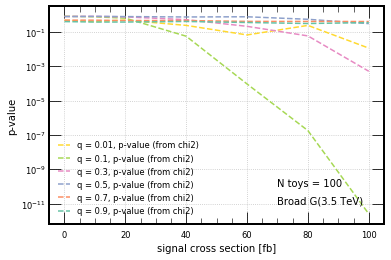

In [47]:
# Make a nice plot
#Color style
scol = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc'] *3
scol.reverse()
bcol = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f'] *3
bcol.reverse()

all_pvals          = {}
all_pvals_fromtoys = {}
all_gofs           = {}
all_exp_gofs       = {}


for key in sorted(columns.keys()): 
    pvals = []
    pvals_fromtoys = []
    gofs = []
    exp_gofs = []
    for si in sig_inj_vals:
        xs = 10*si
        print("\nxsec={}:".format(xs) )
        print("q = {}".format(key) )
        quantile = int(key*100)
        prefix = "q{}_xs{}_{}".format(quantile,xs,tag)

        # open file
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]


        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix))
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
        
        exp_gofs.append(exp_gof)

        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total
        pvals_fromtoys.append(pval_toys)

        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        pvals.append(pval)
        gofs.append(obs_gof)
        print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))
        
        all_pvals          [key] = pvals         
        all_pvals_fromtoys [key] = pvals_fromtoys
        all_gofs           [key] = gofs          
        all_exp_gofs       [key] = exp_gofs      


fig = plt.figure() 
ax = fig.add_subplot(111)
ax.grid()
import cmsstyle 

crossections = np.array(sig_inj_vals)
crossections = crossections * 10


for i,key in enumerate(sorted(columns.keys())): 
    ax.plot(crossections,all_pvals[key],label='q = {}, p-value (from chi2)'.format(key),linestyle='dashed',c=bcol[i])
#     ax.plot(crossections,all_pvals_fromtoys[key],label='q = {}, p-value (from toys)'.format(key),linestyle='solid',c=bcol[i])
# plt.semilogx()
ax.semilogy()
plt.xlabel('signal cross section [fb]')
plt.ylabel('p-value')
ax.text(70, 10e-11, r'N toys = 100')
ax.text(70, 10e-12, r'Broad G(3.5 TeV)')
ax.legend(loc='lower left')
fig.savefig('pvalue_vs_xs_{}.pdf'.format(tag))

For q = 0.1


Warning in <TROOT::Append>: Replacing existing TH1: gof (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: gof_gt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Info in <TCanvas::Print>: pdf file q10_xs0_PDinj_20fbNA_gof.pdf has been created


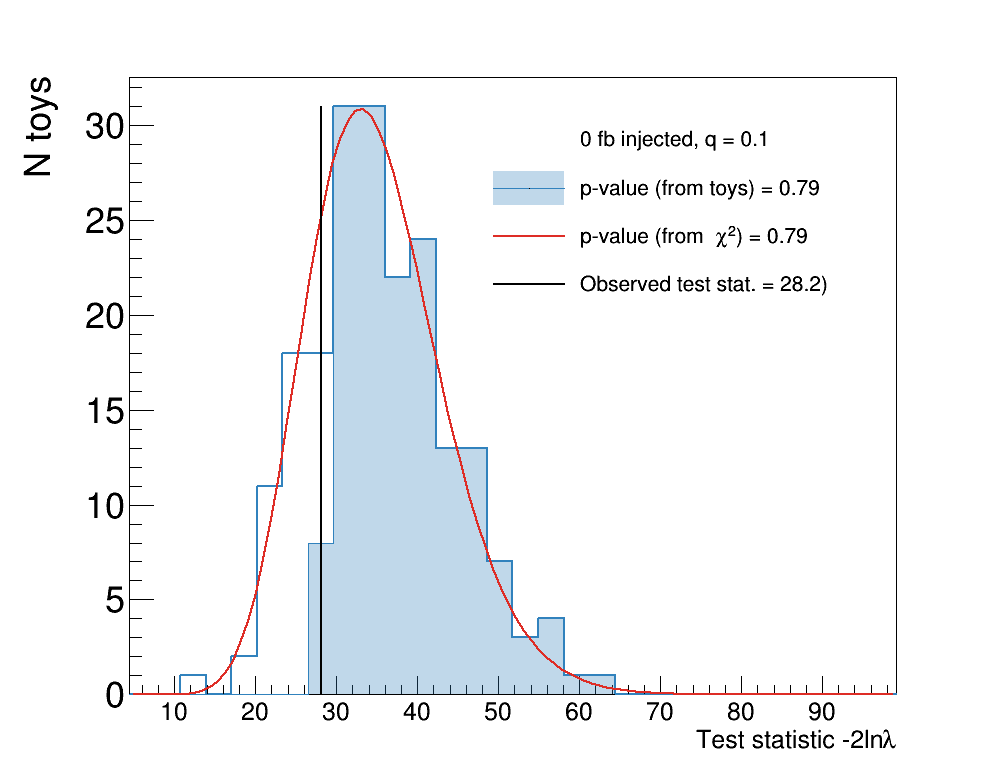

In [32]:
# Plot the test statistic for a given xsec/quantile
bws = 100
scol =['#fc9272','#de2d26','#fee0d2']*2
bcol =['#3182bd','#9ecae1','#deebf7']*2

xs = xsecs[0]
doChecks = True
key = 0.1

if doChecks:
#     print("\nFor xsec={}:".format(xs) )
#     for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
        prefix = "q{}_xs{}_{}".format(quantile,xs,tag)
    
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix)) #limit contains the value of the test-statistic in each toy
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total
        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        # print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))

        bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
        exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        for g in exp_gof:
            exp_gof_hist.Fill(g)
            if g > obs_gof:
                exp_gof_hist_gt.Fill(g)


        d = rt.TCanvas("ratio", "", 1000, 800)
        d.SetLeftMargin(0.13)
        # signal_hist_template    .Draw('same HIST')

        rt.gStyle.SetOptTitle(0)
        rt.gStyle.SetOptStat(0)
        f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))

        tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
        tleg.SetTextSize(0.05)
        tleg.SetBorderSize(0)
        tleg.SetFillStyle(0)
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 62 )
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 42 )
        exp_gof_hist.Draw('hist')
        exp_gof_hist.SetXTitle('Test statistic -2ln#lambda')
        exp_gof_hist.SetYTitle('N toys')
        exp_gof_hist.SetTitle("")
        exp_gof_hist.GetYaxis().SetLabelSize(0.05)
        exp_gof_hist.GetYaxis().SetTitleSize(0.05)
        f.SetLineColor((rt.TColor.GetColor(scol[1])))
        exp_gof_hist.SetLineWidth(2)
        exp_gof_hist.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetFillColorAlpha((rt.TColor.GetColor(bcol[0])), 0.30)
        exp_gof_hist_gt.Draw('fhistsame')
        f.Draw('same')
        line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
        line.SetLineWidth(2)
        line.Draw()
        tleg.AddEntry(None,"{} fb injected, q = {}".format(xs,key),"")
        tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
        tleg.AddEntry(f,'p-value (from #chi^{2}) = %.2f'%pval,'l')
        tleg.AddEntry(line,'Observed test stat. = {:.1f})'.format(obs_gof),'l')
        tleg.Draw()
        latex = rt.TLatex()
        latex.SetNDC ()
        latex.SetTextSize (0.03)
        latex.SetTextFont( 62 )
        # latex.DrawLatex (0.67 ,0.27 , "%.1f fb^{-1} dijet events"%lumi)
        latex.SetTextSize (0.03)
        latex.SetTextFont( 42 )
        # latex.DrawLatex(0.67 ,0.23 , 'q = {} - {}'.format(lower_bound,qkey))
        d.Draw()
        d.SaveAs("{}_gof.pdf".format(prefix))

In [ ]:
# NOT WORKING! Try combining all categories and fit
os.system('combineCards.py q1=datacard_ws_q1_xs{XS}_ratio.txt q10=datacard_ws_q10_xs{XS}_ratio.txt q30=datacard_ws_q30_xs{XS}_ratio.txt q50=datacard_ws_q50_xs{XS}_ratio.txt q70=datacard_ws_q70_xs{XS}_ratio.txt q90=datacard_ws_q90_xs{XS}_ratio.txt &> combined_{XS}.txt'.format(XS=0))
os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d combined_{XS}.txt -n Ratio_combined_{XS} --dataset data_obs -v 3'.format(XS=0))
os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d combined_{XS}.txt  -t 5 --toysFreq -n Ratio_combined_{XS} --dataset data_obs -v 2 -s 42'.format(XS=0))

In [ ]:
# Inspect the fit from fitDiagnostics

xs = xsecs[0]
key = 0.1

print("For q = {}".format(key) )
quantile = int(key*100)
prefix = "q{}_xs{}".format(quantile,xs)
        
os.system('combine -M FitDiagnostics -d datacard_ws_{PREFIX}_ratio.txt  -n _{PREFIX} --saveShapes --saveWithUncertainties --dataset data_obs'.format(PREFIX=prefix))
fitDiag = rt.TFile.Open('fitDiagnostics_{PREFIX}.root'.format(PREFIX=prefix),'r')


f = rt.TCanvas('f','f',1000,800)
f.cd()

tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
tleg.SetTextSize(0.05)
tleg.SetBorderSize(0)
tleg.SetFillStyle(0)
tleg.SetTextSize (0.03)
tleg.SetTextFont( 62 )
tleg.SetTextSize (0.03)
tleg.SetTextFont( 42 )

byhand_gof = 0.0
# for cat in ['q10_rej', 'q10_acc']:
for cat in ['rej', 'acc']:
    print cat
    bkgd = fitDiag.Get('shapes_fit_b/{cat}/background'.format(cat=cat))
    bkgd.Scale(bws) # need to multiply by bin width for some reason?
    data = fitDiag.Get('shapes_fit_b/{cat}/data'.format(cat=cat))
    if cat.find('rej')!=-1:
        bkgd.Draw('hist')
        bkgd.SetLineColor(rt.kRed)
#         bkgd.SetMinimum(10E3)
#         bkgd.SetMaximum(20E3)
#         bkgd.GetXaxis().SetRangeUser(2600,2800)
        tleg.AddEntry(bkgd,'rej','l')
    else:
        bkgd.Draw("histsame")
        tleg.AddEntry(bkgd,'acc','l')
    data.SetMarkerStyle(20)
    data.SetMarkerColor(rt.kBlack)
    for i in range(0,bkgd.GetNbinsX()):
        data.SetPointEXlow(i,0)
        data.SetPointEXhigh(i,0)
        data.SetPoint(i,data.GetX()[i], bws*data.GetY()[i]) # need to multiply by bin width for some reason?
        data.SetPointEYlow(i,bws*data.GetErrorYlow(i)) # need to multiply by bin width for some reason?
        data.SetPointEYhigh(i,bws*data.GetErrorYhigh(i)) # need to multiply by bin width for some reason?
    data.Draw('samepez')


    for i in range(0,bkgd.GetNbinsX()):
        mjjvalue = bkgd.GetBinCenter(i+1)
        fi = bkgd.GetBinContent(i+1)
        di = data.GetY()[i]
        if di == 0:
            print ("No data at mjj", mjjvalue)
            print ("fi", fi)
            print ("di", di)
            gofi = 0.
        else:    
            gofi = 2*(fi - di + di*rt.TMath.Log(di/fi)) # see eq. 14 of http://cousins.web.cern.ch/cousins/ongoodness6march2016.pdf
        # expect each bin to give GOF contribution ~ O(1)
        if gofi>5:
#             print('{cat} bin {i}: fi={fi}, di={di}, gofi={gofi}'.format(cat=cat,i=i,fi=fi,di=di,gofi=gofi))
            print(" Category {}: mjj bin = {} gof = {}".format(cat,mjjvalue,gofi))
        byhand_gof += gofi

tleg.Draw('same')
f.SetLogy()
f.Draw()
f.SaveAs("{}_fitResults_combined.pdf".format(prefix))

print("Done with quantile ",prefix )

print("By hand obs GOF = {}".format(byhand_gof))
obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]
print("Combine obs GOF = {}".format(obs_gof))
# print("Combine exp GOF (mean) = {}".format(np.mean(exp_gof)))

# print("p-value = 
